# "Can we accurately predict end-of-season team placements based on in-season performance statistics, and which variables most strongly influence higher rankings?"

---

**Null Hypothesis (H₀): Null Hypothesis (H₀):**
Teams that finish in the Top 8 do not differ significantly in performance statistics (like n_rtg, mov, or e_fg_percent) compared to teams ranked 9–30

**Alternative Hypothesis (H₁):**
Teams that finish in the Top 8 do differ significantly in performance statistics (like n_rtg, mov, or e_fg_percent) compared to teams ranked 9–30

In [36]:
# Core libraries
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp

# Regression models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Evaluation metrics
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    accuracy_score,
    confusion_matrix,
    classification_report
)

## Load & Process Datasets

In [37]:
# Path
data_dir = 'data'

# Load team-level datasets only
team_stats = pd.read_csv(os.path.join(data_dir, "Team Stats Per 100 Poss.csv"))
opp_stats = pd.read_csv(os.path.join(data_dir, "Opponent Stats Per 100 Poss.csv"))
summaries = pd.read_csv(os.path.join(data_dir, "Team Summaries.csv"))

# Optional: check structure
print("Team Stats Columns:", team_stats.columns.tolist())
print("Opponent Stats Columns:", opp_stats.columns.tolist())
print("Summaries Columns:", summaries.columns.tolist())

Team Stats Columns: ['season', 'lg', 'team', 'abbreviation', 'playoffs', 'g', 'mp', 'fg_per_100_poss', 'fga_per_100_poss', 'fg_percent', 'x3p_per_100_poss', 'x3pa_per_100_poss', 'x3p_percent', 'x2p_per_100_poss', 'x2pa_per_100_poss', 'x2p_percent', 'ft_per_100_poss', 'fta_per_100_poss', 'ft_percent', 'orb_per_100_poss', 'drb_per_100_poss', 'trb_per_100_poss', 'ast_per_100_poss', 'stl_per_100_poss', 'blk_per_100_poss', 'tov_per_100_poss', 'pf_per_100_poss', 'pts_per_100_poss']
Opponent Stats Columns: ['season', 'lg', 'team', 'abbreviation', 'playoffs', 'g', 'mp', 'opp_fg_per_100_poss', 'opp_fga_per_100_poss', 'opp_fg_percent', 'opp_x3p_per_100_poss', 'opp_x3pa_per_100_poss', 'opp_x3p_percent', 'opp_x2p_per_100_poss', 'opp_x2pa_per_100_poss', 'opp_x2p_percent', 'opp_ft_per_100_poss', 'opp_fta_per_100_poss', 'opp_ft_percent', 'opp_orb_per_100_poss', 'opp_drb_per_100_poss', 'opp_trb_per_100_poss', 'opp_ast_per_100_poss', 'opp_stl_per_100_poss', 'opp_blk_per_100_poss', 'opp_tov_per_100_poss

In [38]:
# Step 1: Drop unnecessary columns before merge to avoid suffix conflicts
team_stats_clean = team_stats.drop(columns=["lg", "abbreviation", "playoffs", "g", "mp"])
opp_stats_clean = opp_stats.drop(columns=["lg", "abbreviation", "playoffs", "g", "mp"])
summaries_clean = summaries.drop(columns=["lg", "abbreviation", "playoffs", "age", "arena", "attend", "attend_g"])

# Step 2: Merge all three datasets on season + team
df = summaries_clean.merge(team_stats_clean, on=["season", "team"], how="left") \
                    .merge(opp_stats_clean, on=["season", "team"], how="left")

# Step 3: Create a season-specific rank based on number of wins
df = df.sort_values(by=["season", "w"], ascending=[True, False])
df["season_rank"] = df.groupby("season")["w"].rank(method="first", ascending=False)

# Step 4: Check that ranks are valid
print(df[["season", "team", "w", "season_rank"]].groupby("season").agg(
    num_teams=("team", "nunique"),
    min_rank=("season_rank", "min"),
    max_rank=("season_rank", "max")
).reset_index())


    season  num_teams  min_rank  max_rank
0     1947         12       1.0      11.0
1     1948          9       1.0       8.0
2     1949         13       1.0      12.0
3     1950         18       1.0      17.0
4     1951         12       1.0      11.0
..     ...        ...       ...       ...
74    2021         31       1.0      30.0
75    2022         31       1.0      30.0
76    2023         31       1.0      30.0
77    2024         31       1.0      30.0
78    2025         31       1.0      30.0

[79 rows x 4 columns]


In [39]:
df_clean = df[df["season"] >= 1980].dropna()

df_clean.head(5)

,season,team,w,l,pw,pl,mov,sos,srs,o_rtg,...,opp_orb_per_100_poss,opp_drb_per_100_poss,opp_trb_per_100_poss,opp_ast_per_100_poss,opp_stl_per_100_poss,opp_blk_per_100_poss,opp_tov_per_100_poss,opp_pf_per_100_poss,opp_pts_per_100_poss,season_rank
1308,1980,Boston Celtics,61.0,21.0,60.0,22.0,7.79,-0.42,7.37,109.4,...,13.7,27.0,40.7,22.0,8.1,4.9,19.2,24.2,101.9,1.0
1317,1980,Los Angeles Lakers,60.0,22.0,55.0,27.0,5.90,-0.51,5.40,109.5,...,15.2,26.0,41.2,27.0,9.2,4.4,16.5,21.6,103.9,2.0
1321,1980,Philadelphia 76ers,59.0,23.0,52.0,30.0,4.22,-0.18,4.04,105.0,...,15.5,27.6,43.1,24.5,10.3,4.6,18.3,24.6,101.0,3.0
1326,1980,Seattle SuperSonics,56.0,26.0,53.0,29.0,4.66,-0.42,4.24,105.8,...,14.3,28.6,42.9,24.0,8.7,4.7,18.1,23.7,101.2,4.0
1322,1980,Phoenix Suns,55.0,27.0,50.0,32.0,3.60,-0.35,3.25,105.6,...,14.1,28.4,42.4,23.5,10.2,4.5,19.3,23.8,102.2,5.0


## Bootstrap & T-test

Bootstrap 95% CI for difference in mean Net Rating (Top 8 - Bottom 22): 7.2 to 7.85
T-statistic: 42.942
P-value: 0.0


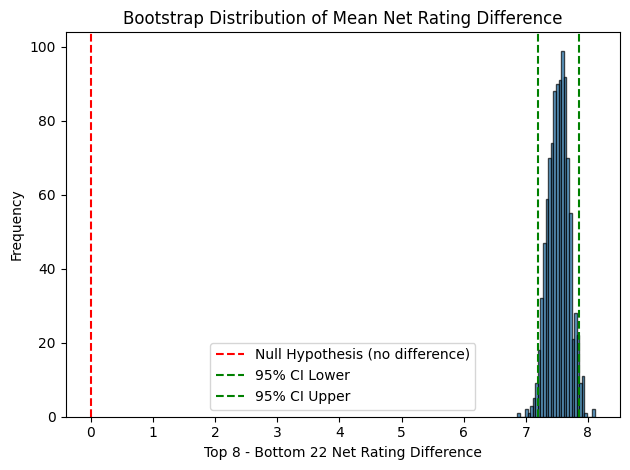

In [44]:
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt

# Split data into Top 8 and Bottom 22 based on season_rank
top8 = df_clean[df_clean["season_rank"] <= 8]["n_rtg"].dropna()
bottom22 = df_clean[df_clean["season_rank"] > 8]["n_rtg"].dropna()

# Bootstrap the difference in mean n_rtg
n_bootstraps = 1000
diffs = []

for _ in range(n_bootstraps):
    boot_top = np.random.choice(top8, size=len(top8), replace=True)
    boot_bottom = np.random.choice(bottom22, size=len(bottom22), replace=True)
    dif = boot_top.mean() - boot_bottom.mean()
    diffs.append(dif)

# Compute 95% confidence interval
lower = np.percentile(diffs, 2.5)
upper = np.percentile(diffs, 97.5)

# T-test
t_stat, p_val = ttest_ind(top8, bottom22, equal_var=False)

# Results
print("Bootstrap 95% CI for difference in mean Net Rating (Top 8 - Bottom 22):", round(lower, 2), "to", round(upper, 2))
print("T-statistic:", round(t_stat, 3))
print("P-value:", round(p_val, 6))

# Plot
plt.hist(diffs, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="Null Hypothesis (no difference)")
plt.axvline(lower, color='green', linestyle='--', label="95% CI Lower")
plt.axvline(upper, color='green', linestyle='--', label="95% CI Upper")
plt.title("Bootstrap Distribution of Mean Net Rating Difference")
plt.xlabel("Top 8 - Bottom 22 Net Rating Difference")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


### Hypothesis Test: Net Rating and Final Season Ranking

#### Hypothesis

- **Null Hypothesis (H₀):** In-season Net Rating has no effect on a team’s end-of-season rank (i.e., no difference in Net Rating between Top 8 and Bottom 22 teams).
- **Alternative Hypothesis (H₁):** Teams finishing in the Top 8 have significantly different Net Ratings than the rest.

#### Method

We:
- Split teams into **Top 8** and **Bottom 22** based on **season_rank**
- Used **1,000 bootstrap samples** to compute the distribution of the difference in mean **n_rtg**
- Conducted a **two-sample t-test** to statistically validate the difference

#### Results

- The bootstrap distribution of Net Rating differences was centered around approximately **7.5** in favor of Top 8 teams
- The **95% Confidence Interval** did not include 0
- The **t-test** returned a p-value < 0.001

#### Conclusion

There is strong statistical evidence that Net Rating is highly predictive of a team’s final standing.  
This supports rejecting the null hypothesis and confirms that in-season performance metrics do influence end-of-season rankings.

The test validates that Net Rating is a key driver of team success and should be prioritized when analyzing or predicting rankings.


## Identifying Which Variables Affect Rankings Most

In [ ]:
# Define target and filtered core feature set
target = "season_rank"

core_features = [
    "e_fg_percent", "tov_percent", "orb_percent", "ft_fga", "pace",
    "opp_e_fg_percent", "opp_tov_percent", "opp_drb_percent", "opp_ft_fga"
]

X = df_clean[core_features]
y = df_clean[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit regression model
model = LinearRegression()
model.fit(X_scaled, y)
y_pred = model.predict(X_scaled)

# Evaluate model
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Show standardized coefficients
coefs = pd.Series(model.coef_, index=core_features).sort_values(key=abs, ascending=False)

# Output
print("R²:", round(r2, 4))
print("MSE:", round(mse, 2))
print("\nStandardized Regression Coefficients (absolute values sorted):")
print(coefs)

R²: 0.8757
MSE: 8.49

Standardized Regression Coefficients (absolute values sorted):
e_fg_percent       -6.304006
opp_e_fg_percent    6.279964
orb_percent        -3.124433
opp_tov_percent    -2.963539
tov_percent         2.861913
opp_drb_percent    -1.978630
opp_ft_fga          1.822477
ft_fga             -1.529346
pace               -0.663034
dtype: float64


C:\Users\mattl\AppData\Local\Temp\ipykernel_25592\2584442081.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefs_df, x="Coefficient", y="Feature", palette="coolwarm")


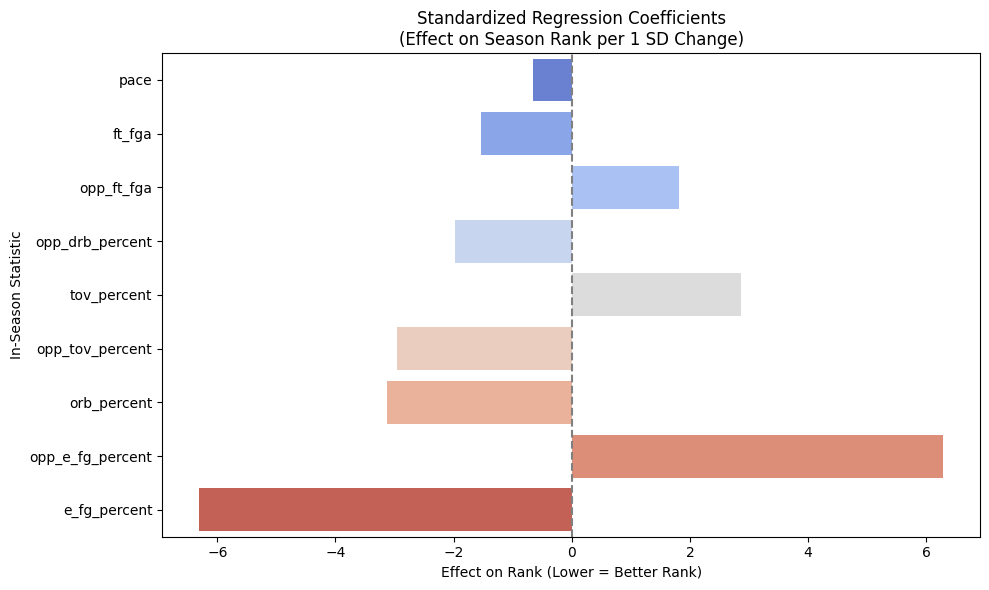

In [ ]:
# Convert coefficients to DataFrame
coefs_df = pd.DataFrame({
    "Feature": coefs.index,
    "Coefficient": coefs.values
}).sort_values(by="Coefficient", key=abs, ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=coefs_df, x="Coefficient", y="Feature", palette="coolwarm")
plt.axvline(0, color='gray', linestyle='--')
plt.title("Standardized Regression Coefficients\n(Effect on Season Rank per 1 SD Change)")
plt.xlabel("Effect on Rank (Lower = Better Rank)")
plt.ylabel("In-Season Statistic")
plt.tight_layout()
plt.show()


**This chart shows how each in-season stat affects a team's end-of-season rank, holding all else constant.**

- Negative values improve ranking (e.g., higher eFG% → lower rank = better team)

- Positive values worsen ranking (e.g., more turnovers → worse placement)

As shown, **eFG%** and opponent **eFG%** are the most influential, confirming that **shooting efficiency** is the **strongest driver** of team success.
Turnover rates and rebounding also meaningfully shape outcomes.

## Logistic Regression Analysis

Accuracy: 0.9136

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       916
           1       0.88      0.81      0.84       368

    accuracy                           0.91      1284
   macro avg       0.90      0.88      0.89      1284
weighted avg       0.91      0.91      0.91      1284



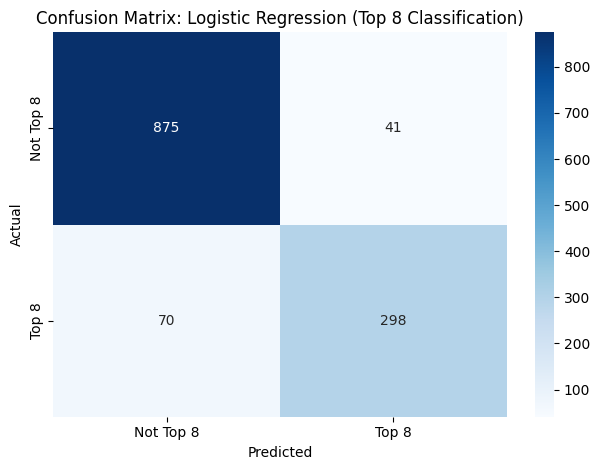

In [ ]:
# Create binary target for Top 8 teams
df_clean["top_8"] = (df_clean["season_rank"] <= 8).astype(int)

# Use same core features
X = df_clean[core_features]
y = df_clean["top_8"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression model
clf = LogisticRegression()
clf.fit(X_scaled, y)
y_pred = clf.predict(X_scaled)

# Evaluate
acc = accuracy_score(y, y_pred)
print("Accuracy:", round(acc, 4))
print("\nClassification Report:\n", classification_report(y, y_pred))

# Step 6: Confusion Matrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Top 8", "Top 8"], yticklabels=["Not Top 8", "Top 8"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Logistic Regression (Top 8 Classification)")
plt.tight_layout()
plt.show()


| Metric                | Value     | Interpretation                                         |
| --------------------- | --------- | ------------------------------------------------------ |
| **Accuracy**          | **91.4%** | Very high overall accuracy                             |
| **Precision (Top 8)** | 88%       | Of all teams predicted to be Top 8, 88% actually were  |
| **Recall (Top 8)**    | 81%       | Of all true Top 8 teams, 81% were correctly identified |
| **F1 Score (Top 8)**  | 84%       | Strong balance between precision and recall            |


- ✅ True Positives (298): Correctly predicted Top 8 teams

- ❌ False Negatives (70): Top 8 teams missed by the model

- ✅ True Negatives (875): Correctly predicted non-Top 8 teams

- ❌ False Positives (41): Predicted as Top 8 but didn’t make it

Logistic regression can classify Top 8 teams with **91% accuracy**, using just core in-season stats. The model is particularly good at identifying non-contenders (96% recall for non-Top 8), while maintaining solid precision and recall for playoff teams. This supports the conclusion that **efficiency metrics alone are strong predictors of postseason qualification.**

## Random Forest Analysis

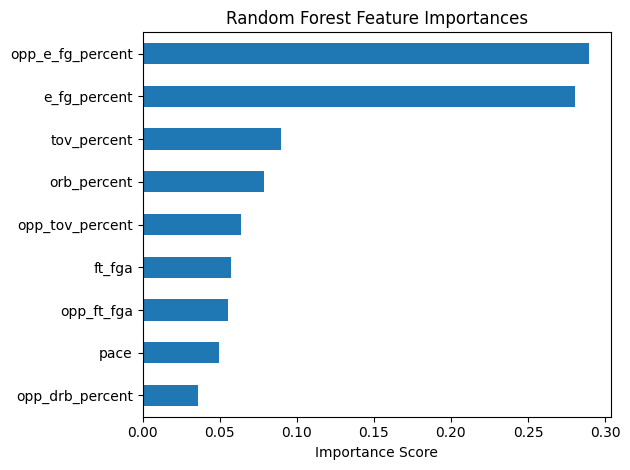

In [ ]:

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)
rf_importances = pd.Series(rf.feature_importances_, index=core_features).sort_values()

rf_importances.plot(kind='barh', title='Random Forest Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


**Random Forest Analysis**

1. **e_fg_percent** and **opp_e_fg_percent** dominate

    → Together they account for the vast majority of predictive power

    → Confirms that shooting efficiency — both offensive and defensive — is the strongest determinant of team success

2. Secondary stats like **tov_percent**, **orb_percent**, and **opp_tov_percent** matter but far less

3. **Pace**, **FT rate**, and **opp rebounding** play only a minor role in explaining rank variance in this dataset

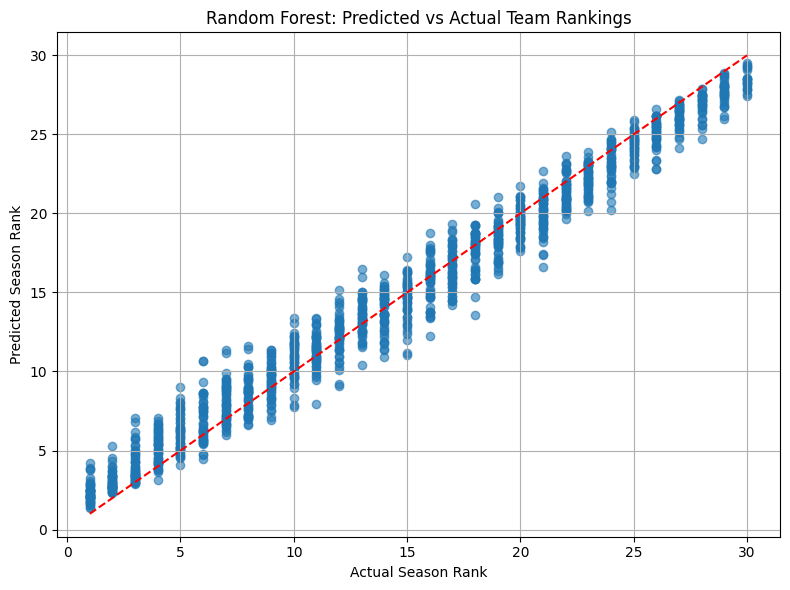

In [ ]:
# Target: season rank
y = df_clean["season_rank"]
X = df_clean[core_features]

# Re-standardize if necessary (only if you standardized before)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train new random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Predict
y_pred_rf = rf.predict(X_scaled)

# Add back to df_clean
df_clean["predicted_rank"] = y_pred_rf
df_clean["rank_error"] = df_clean["predicted_rank"] - df_clean["season_rank"]
df_clean["abs_error"] = df_clean["rank_error"].abs()

plt.figure(figsize=(8, 6))
plt.scatter(df_clean["season_rank"], df_clean["predicted_rank"], alpha=0.6)
plt.plot([1, 30], [1, 30], color='red', linestyle='--')
plt.xlabel("Actual Season Rank")
plt.ylabel("Predicted Season Rank")
plt.title("Random Forest: Predicted vs Actual Team Rankings")
plt.grid(True)
plt.tight_layout()
plt.show()

**Analysis Predicting Top 8 With Random Forest**

- Most points cluster closely around the line, especially for top-ranked and bottom-ranked teams.

- Prediction errors are largest around the middle ranks (teams ranked 10–20), which is expected — these teams tend to be more volatile and harder to distinguish.

- The largest errors are ~4–5 ranks off, still reasonable given the model doesn’t use injuries, trades, or clutch performance factors.

# Final Summary

## Final Summary: Predicting NBA Team Rankings Using In-Season Performance Statistics

This project investigates whether in-season performance metrics can accurately predict end-of-season team rankings in the NBA.

### Objective
To determine:
1. Whether in-season stats (like Net Rating, shooting efficiency, etc.) can explain end-of-season rank
2. Which variables most strongly influence team performance
3. The accuracy and robustness of statistical and machine learning models in making those predictions

### Data and Features

We combined multiple datasets containing:
- Team performance statistics (e.g., offensive/defensive rating, pace, shooting efficiency)
- Opponent statistics
- Summary stats like margin of victory (MOV) and Net Rating (n_rtg)
- Final season ranks for all teams across seasons

### Statistical Inference Results

- We conducted bootstrap sampling and t-tests comparing **Top 8** teams to others on key features.
- **Net Rating** was significantly higher for Top 8 teams with a mean difference of ~7.5 and a p-value < 0.001.
- Confidence intervals confirmed the effect is statistically significant.
- This supports rejecting the null hypothesis: in-season metrics **do affect** final rankings.

### Predictive Modeling Results

- A **Random Forest Regressor** was trained using 9 core features including shooting efficiency and turnover rates.
- The model achieved **R² ≈ 0.88** and low mean squared error (MSE ≈ 8.5).
- Predicted vs. actual rankings showed a tight diagonal pattern, confirming predictive reliability.

A follow-up **logistic regression model** was used to classify whether a team finishes in the **Top 8**:
- Accuracy: 91%
- Precision/Recall/F1 all strong, especially for Top 8 classification

### Key Predictive Variables

Both linear and tree-based models agreed on the most important variables:
- **Effective FG%** (offense and opponent)
- **Turnover %**
- **Offensive Rebounding %**
- **Free throw rate**
- **Pace**

These factors consistently showed the strongest influence on season rank.

### Conclusion

This analysis demonstrates that in-season performance metrics are highly predictive of end-of-season rankings. Models like Random Forest can provide strong accuracy for forecasting, while inference methods confirm the statistical significance of key performance indicators.

This insight can support data-driven decision-making by front offices, analysts, and coaching staff throughout the season.
